In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

In [3]:
data = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/conversion_project.csv')

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
data.groupby(['country']).size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [7]:
data.groupby(['source']).size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

In [8]:
print(sorted(data['age'].unique(), reverse=True))
[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


[123,
 111,
 79,
 77,
 73,
 72,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17]

In [11]:
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


In [12]:
data[data['age']>110]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [15]:
data.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [13]:
data = data[data['age']<110]

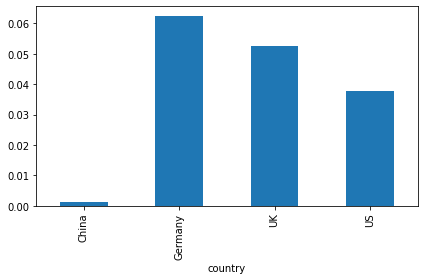

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

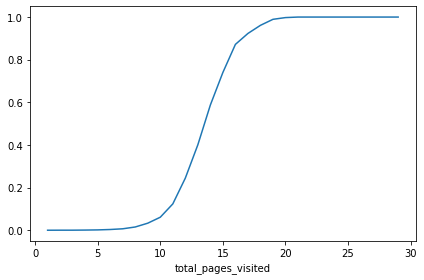

In [16]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

In [17]:
#dummy variables for the categorical ones
data_dummy = pandas.get_dummies(data, drop_first=True)

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
from numpy.core.umath_tests import inner1d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)

In [20]:
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)

In [21]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
#let's print OOB accuracy and confusion matrix
print("OOB accuracy is", rf.oob_score_, "\n", "OOB Confusion Matrix", "\n",pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9838851885571901 
 OOB Confusion Matrix 
         0     1
0  200872  1102
1    2261  4455


In [24]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


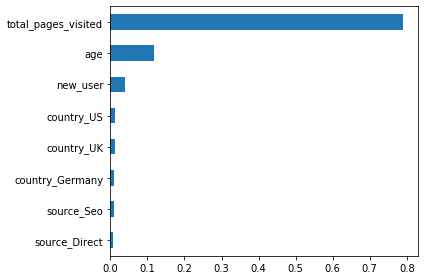

In [25]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')

In [26]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [27]:
#Out Of Bag Error is described as the fraction of number incorrect classifications over number of out of bag samples.
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978


In [28]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


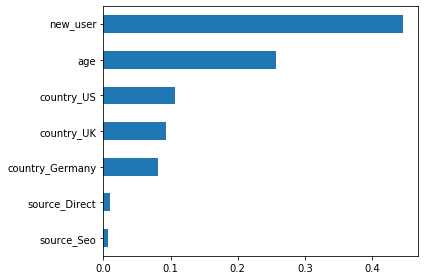

In [29]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [30]:
from pdpbox import pdp, info_plots

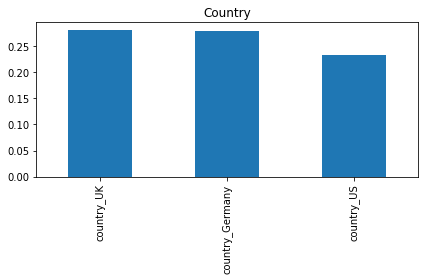

In [31]:
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

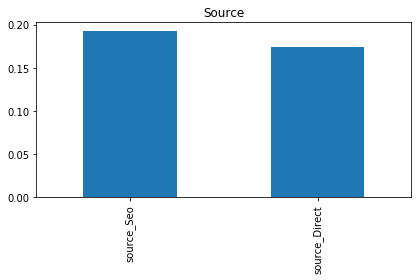

In [32]:
#source
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

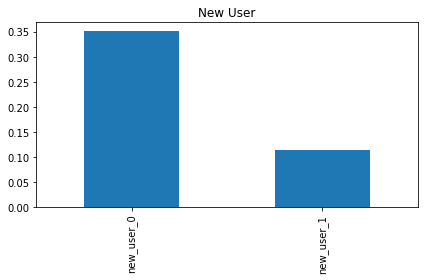

In [33]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

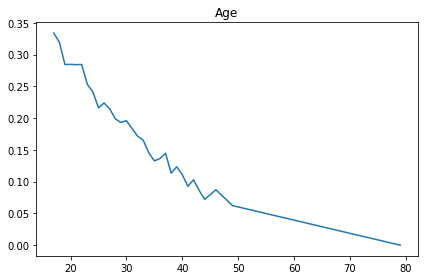

In [34]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()